# Derive mask for open ocean grid boxes for CERES SYN1deg hourly data

We build a time-constant mask of open ocean grid cells using the variable 'aux\_ocean\_1h' of the CERES data. 'aux\_ocean\_1h' is 100\% for open ocean, but smaller if there is land or sea ice. Because sea ice depends on time, 'aux\_ocean\_1h' also depends on time. Here, we take the conservative approach and define a grid cell to be open ocean only if 'aux\_ocean\_1h' is 100\% for all time steps of Sep and Oct 2016.

Additional notes: 
* We assume that the CERES data was obtained previously and interpolated to a 1x1 deg lat-lon grid using cdo remapcon for a region covering the North Atlantic. 
* We use both the Terra-Aqua-Modis aas well as the Terra-NPP product. 
* The notebook is written for Mistral at DKRZ.

In [1]:
import numpy as np
import xarray as xr

Generate open ocean mask individually for Terra-Aqua-Modis and Terra-NPP products

In [2]:
oomask_list = [] 
for product in ['Terra-Aqua-MODIS_Ed4A','Terra-NPP_Ed1A']:
    aux_ocean_1h = ( xr.open_mfdataset('/work/bb1018/b380459/OBS/CERES/CERES_SYN1deg/'+
                     'CERES_SYN1deg-1H_'+product+'_Subset_201609-201610.gridr1x1.nc', 
                     combine='by_coords', parallel=True, chunks={'time': 1})
                     ['aux_ocean_1h'] )
     
    # conservative maks of open ocean: time min of aux_ocean_1h
    oomask_list.append(xr.ufuncs.floor(0.01*aux_ocean_1h.min('time')).rename('oomask'))

Generate conservative joint open ocean mask: only grid cells that were classified as open ocean in both Terra-Aqua-Modis and Terra-NPP will be kept as open ocean cells. Finally the mask is saved to a netcdf file.

In [3]:
oomask = xr.ufuncs.floor(0.5*(oomask_list[0]+oomask_list[1]))
oomask.to_netcdf('/work/bb1018/b380459/OBS/CERES/CERES_SYN1deg/CERES_SYN1deg_201609-201610.gridr1x1.openoceanmask.nc')

For illustration purposes, the mask is plotted below.

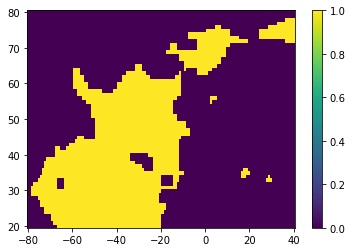

In [4]:
import matplotlib.pyplot as plt

lons = np.hstack([oomask.lon.values-0.5, oomask.lon.values[-1]+0.5])
lats = np.hstack([oomask.lat.values-0.5, oomask.lat.values[-1]+0.5])

plt.pcolormesh(lons, lats, oomask)
plt.colorbar()